# Load and clean Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [4]:
df = pd.read_csv('OilPrice.csv', parse_dates = ['Datetime'], index_col = ['Datetime'], )

In [5]:
df.head()

,Oil
Datetime,
2008-06-01,5138
2008-07-01,5177
2008-08-01,5003
2008-09-01,3974
2008-10-01,4738


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 2008-06-01 to 2018-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Oil     121 non-null    int64
dtypes: int64(1)
memory usage: 1.9 KB


# Multiplicative Decomposition

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
def multiplicative_decomposition(data):
    result = seasonal_decompose(data, model='multiplicative')

    # Assign decomposed components to variables
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    # Plotting the components
    import matplotlib.pyplot as plt

    plt.figure(figsize=(20, 20))

    plt.subplot(411)
    plt.plot(data, label='Original', marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.subplot(412)
    plt.plot(trend, label='Trend', marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal',marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.subplot(414)
    plt.plot(residual, label='Residuals',marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

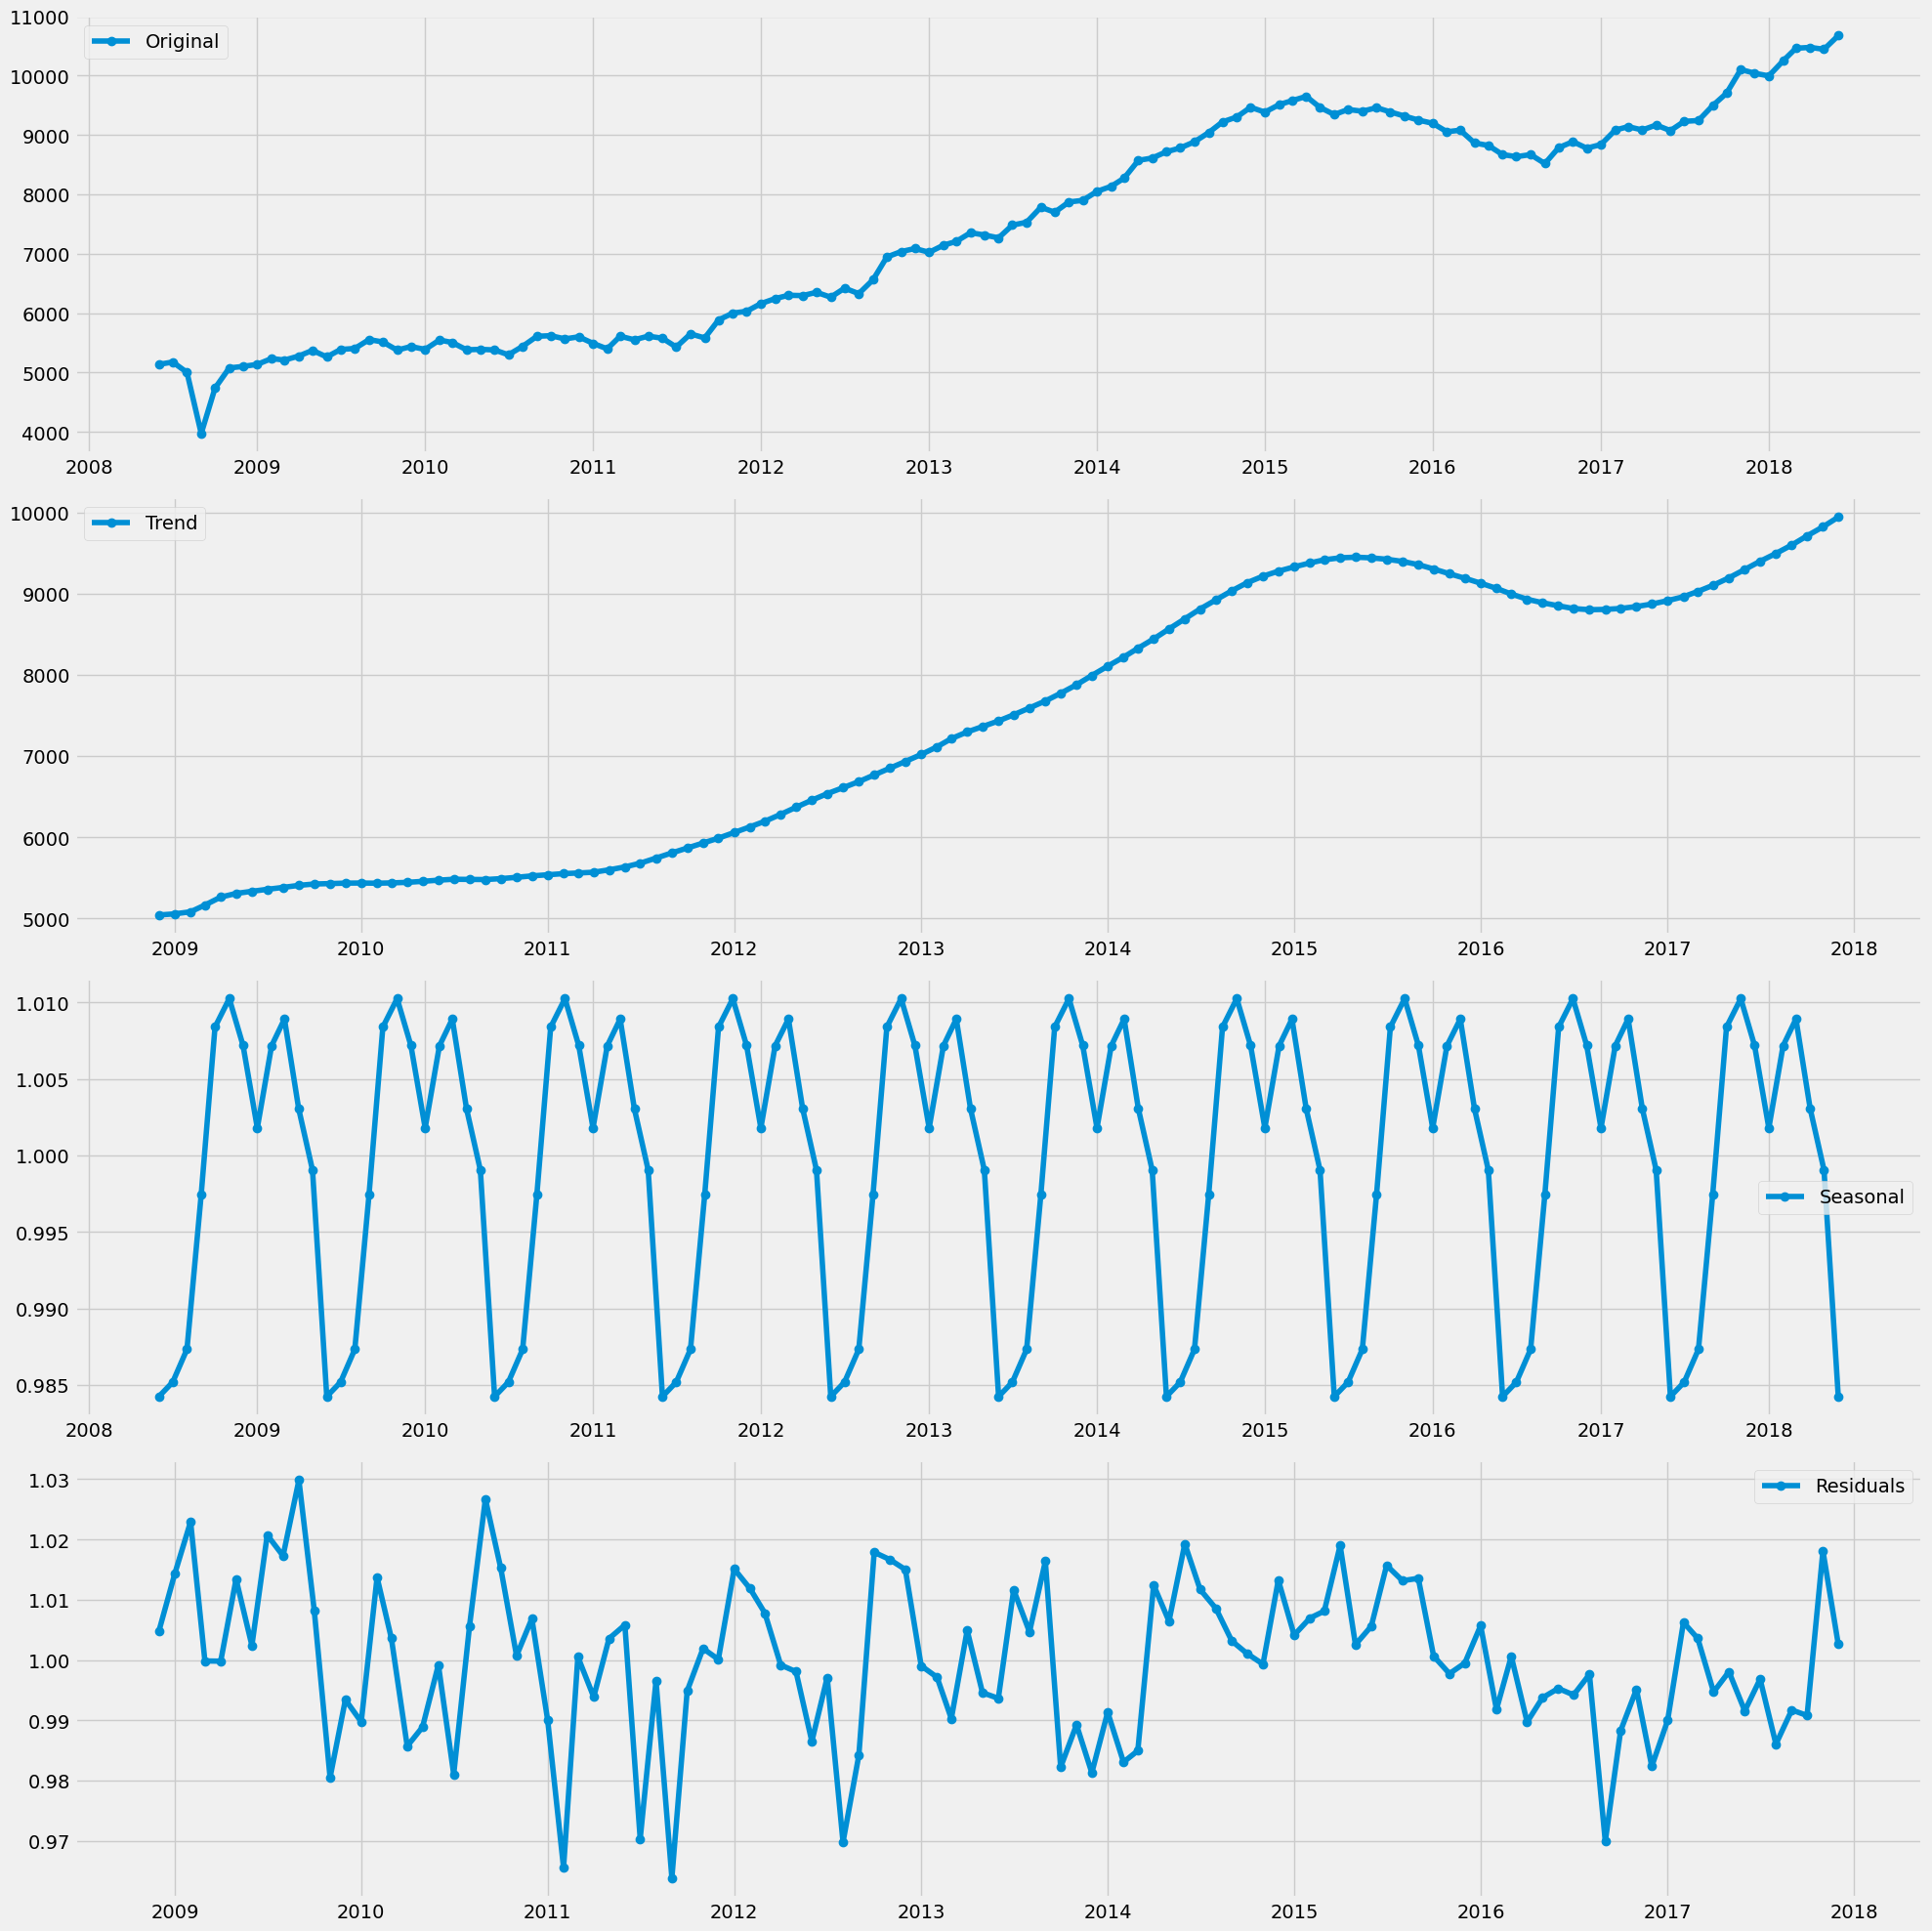

In [8]:
multiplicative_decomposition(df['Oil'])

# Checking Seasonality

In [16]:
def check_seasonality(data):
    # Perform seasonal decomposition
    decomposition = sm.tsa.seasonal_decompose(data)
    
    # Plot the decomposition
    decomposition.plot()
    plt.show()
    
    # Check for seasonality based on the seasonal component
    seasonal_component = decomposition.seasonal
    seasonal_std = seasonal_component.std()
    
    # Define a threshold for detecting seasonality
    threshold = 0.05
    
    if seasonal_std > threshold:
        print("Seasonality detected in the data.")
    else:
        print("No clear seasonality detected in the data.")

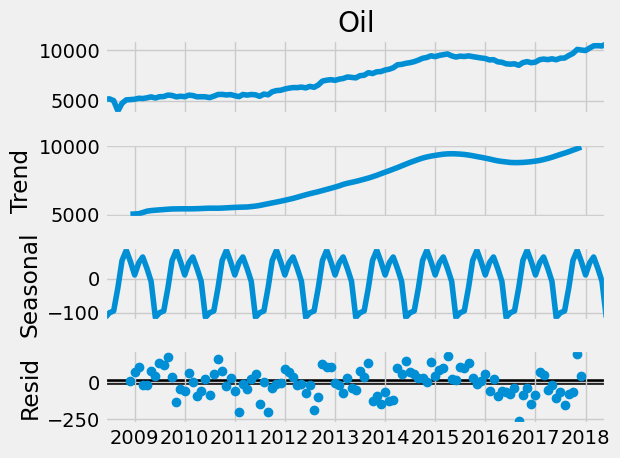

Seasonality detected in the data.


In [17]:
check_seasonality(df['Oil'])

# Checking Stationary

In [9]:
def check_stationary(data):
    # Perform ADF test to check stationarity
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] < 0.05:
        print("The differentiated series is likely stationary (reject the null hypothesis)")
    else:
        print("The differentiated series is likely non-stationary (fail to reject the null hypothesis)")

In [10]:
check_stationary(df['Oil'])

ADF Statistic: 0.26271392890470746
p-value: 0.9755676444885656
Critical Values:
   1%: -3.486055829282407
   5%: -2.8859430324074076
   10%: -2.5797850694444446
The differentiated series is likely non-stationary (fail to reject the null hypothesis)


In [11]:
def differentiate_and_check_stationary(series, diff_order):
    # Differentiate the series the specified number of times
    differentiated_series = series.diff(diff_order).dropna()
    
    # Plot the differentiated series
    plt.figure(figsize=(10, 6))
    plt.plot(differentiated_series.index, differentiated_series.values, label=f'{diff_order}th Order Difference')
    plt.title(f'{diff_order}th Order Difference of Time Series')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Perform ADF test to check stationarity
    result = adfuller(differentiated_series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] < 0.05:
        print("The differentiated series is likely stationary (reject the null hypothesis)")
    else:
        print("The differentiated series is likely non-stationary (fail to reject the null hypothesis)")

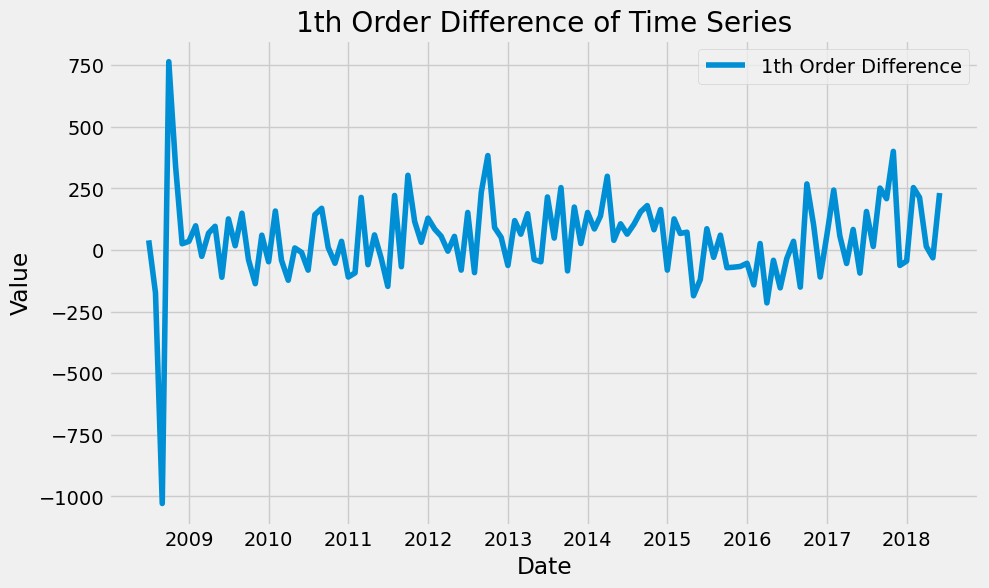

ADF Statistic: -8.50487693452379
p-value: 1.2104550397088313e-13
Critical Values:
   1%: -3.4870216863700767
   5%: -2.8863625166643136
   10%: -2.580009026141913
The differentiated series is likely stationary (reject the null hypothesis)


In [12]:
differentiate_and_check_stationary(df['Oil'],1)

## Plot ACF-PACF

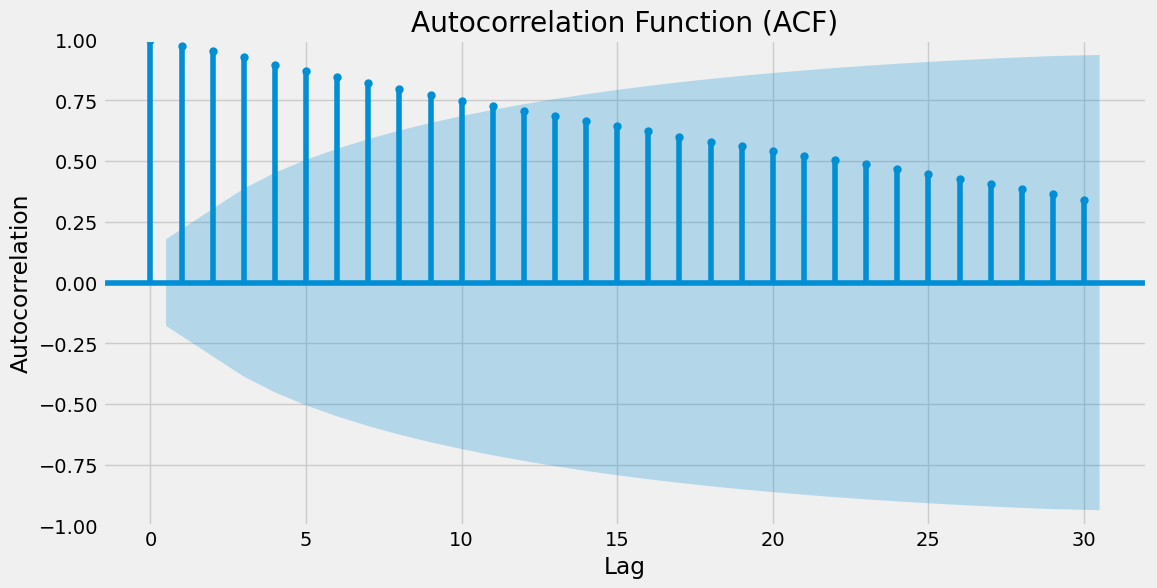

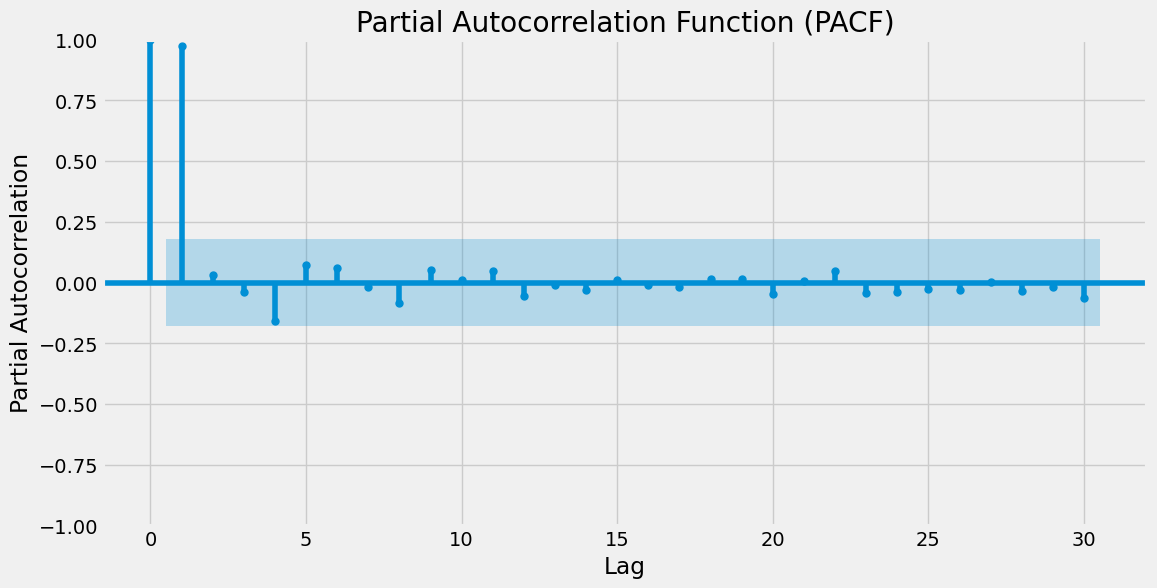

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=None):
    # Plot ACF
    plt.figure(figsize=(12, 6))
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()
    
    # Plot PACF
    plt.figure(figsize=(12, 6))
    plot_pacf(series, lags=lags, ax=plt.gca())
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.show()

# Example usage:
# Assuming df is your DataFrame and 'Oil' is the column you want to model
plot_acf_pacf(df['Oil'], lags=30)  # You can adjust the number of lags as needed

# ARIMA Model

In [14]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def fit_arima_model(data, order):
    # Fit ARIMA model
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    
    # Get predicted values
    predicted_values = model_fit.predict()
    
    # Create DataFrame with original and predicted values
    df = pd.DataFrame({'Original Data': data, 'Predicted Values': predicted_values}, index=data.index)
    
    
    # Plot original data and predicted values
    df.plot()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('ARIMA Model - Original Data vs Predicted Values')
    plt.show()
    

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(data[1:], predicted_values[1:]))
    print(F"Root Mean Squared Error (RMSE):, {rmse}")

    df['error_percentage'] = abs((df['Original Data'] - df['Predicted Values'])/df['Original Data']*100)
    df = df[1:]
    error_percentage_mean = df['error_percentage'].mean()
    error_percentage_std = df['error_percentage'].std()
    print(f"error_percentage_mean: {error_percentage_mean:2}")
    print(f"error_percentage_std: {error_percentage_std:2}")
    
    # Predict the next day's value
    next_day_prediction = model_fit.forecast(steps=1)[0]
    print(f"Current value for this month: {data[-1]}")
    print(f"Predicted value for the next month: {next_day_prediction}")
    
    return df

c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\m.pham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


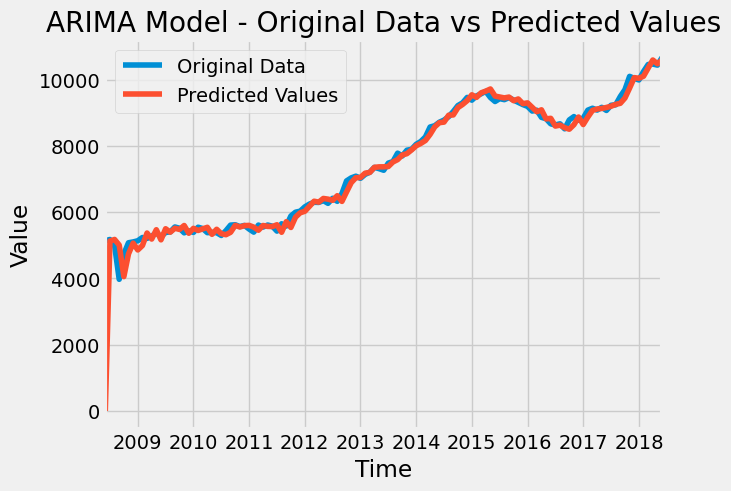

Root Mean Squared Error (RMSE):, 173.51488095390636
error_percentage_mean: 1.7829304920574214
error_percentage_std: 2.858194422839612
Current value for this month: 10674
Predicted value for the next month: 10729.055973673407


In [15]:
df_result = fit_arima_model(df['Oil'], order = (11,1,2))